# Лабораторная работа № 8.1
## Определение постоянных Стефана-Больцмана и Планка из анализа теплового излучения накаленного тела
При помощи модели абсолютно чёрного тела (АЧТ) проводятся измерения температуры оптическим пирометром с исчезающей нитью и термопарой, исследуется излучение накаленных тел с различной испускательной способностью, определяются постоянные Планка и Стефана-Больцмана

In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.interpolate as scpint
import scipy.odr as odr

### Изучение работы оптического пирометра
Необходимо убедиться, что значения температуры, получаемые обоими способами (с помощью пирометра и термопары), мало отличаются друг от друга (не более 5%) и, следовательно, оптический пирометр работает исправно.

* $T_{пир} = 1105°С$
* $T_{комн}=23°С$
* $T_{терм}=1169°С$
* $\Delta T = 64°С$ – примерно 5% 

Делаем вывод, что прибор работает корректно.

### Измерение яркостной температуры накаленных тел
Этот эксперимент должен показать, что различные тела, имеющие одинаковую $T_{терм}$, имеют разные $T_{ярк}$.

* $T_{трубки}=749°С$ (материал: керамика)
* $T_{правое кольцо}=700°С$ (материал: какой-то металл)
* $T_{левое кольцо}=714°С$ (материал: какой-то металл)

**Вывод (почему $T_{ярк}$ разные):** яркостная температура тела характеризует интенсивность излучения. Так как исследуемые тела не являются АЧТ, то их яркостная температура тела меньше термодинамической, поскольку любое не АЧТ излучает меньше, чем АЧТ при той же термодинамической температуре. И в связи с тем, что материалы разные, то поправка в нахождении $T_{ярк}$ зависит от материала.

### Проверка закона Стефана-Больцмана
Загрузим полученные данные

In [2]:
dataC = pd.read_csv("data1.csv")
dataC

,"Tярк, °С","I, А","U, В"
0,930,0.721,3.33
1,990,0.806,4.24
2,1080,0.905,5.40
3,1175,1.035,7.07
4,1260,1.103,8.01
5,1450,1.100,8.01


Получим яркостную температуру в Кельвинах.

In [3]:
dataK = pd.DataFrame(dataC.values.T[0] + 273)
dataK.columns =['Tярк(K)']
dataK

,Tярк(K)
0,1203
1,1263
2,1353
3,1448
4,1533
5,1723


C помощью графика получим термодинамическую температуру

In [5]:
dataK['Tтерм(K)'] = pd.Series([
        1250,
        1300,
        1390,
        1500,
        1580,
        1760
    ])
dataK

,Tярк(K),Tтерм(K)
0,1203,1250
1,1263,1300
2,1353,1390
3,1448,1500
4,1533,1580
5,1723,1760


Переведём термодинамическую температуру из Кельвинов в Цельсии и добавим к исходным данным

In [6]:
dataC['Tтерм(°C)'] = dataK['Tтерм(K)'] - 273
dataC

,"Tярк, °С","I, А","U, В",Tтерм(°C)
0,930,0.721,3.33,977
1,990,0.806,4.24,1027
2,1080,0.905,5.40,1117
3,1175,1.035,7.07,1227
4,1260,1.103,8.01,1307
5,1450,1.100,8.01,1487


Добавим сюда также потребляемую мощность: $W = U \cdot I$(Вт)

In [7]:
dataC['W, Вт'] = np.round(dataC['U, В']*dataC['I, А'],3)
dataC

,"Tярк, °С","I, А","U, В",Tтерм(°C),"W, Вт"
0,930,0.721,3.33,977,2.401
1,990,0.806,4.24,1027,3.417
2,1080,0.905,5.40,1117,4.887
3,1175,1.035,7.07,1227,7.317
4,1260,1.103,8.01,1307,8.835
5,1450,1.100,8.01,1487,8.811


In [8]:
# Функция для регрессии Деминга: https://docs.scipy.org/doc/scipy/reference/odr.html
def f(B, x):
    return B[0]*x**2 +B[1]*x+B[2]

def g(B, x):
    return B[0]*x + B[1]

square = odr.Model(f)
linear = odr.Model(g)

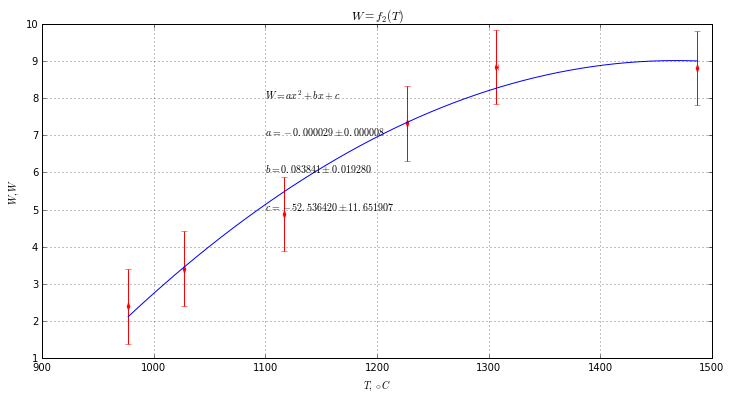

In [9]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot()


y = dataC['W, Вт'].values
yerr = [1 for i in range(len(y))]
x = dataC['Tтерм(°C)'].values
xerr = [1 for i in range(len(x))]

mydata = odr.RealData(x, y, sx=xerr, sy=yerr)
myodr = odr.ODR(mydata, square, beta0=[1.,2., 3.])
myoutput = myodr.run()

x_new = np.linspace(x[0], x[-1], 50)
y_new = square.fcn(myoutput.beta, x_new)

plt.xlabel("$T, \circ C$")
plt.ylabel("$W, W$")
plt.title("$W = f_{2}(T)$")
plt.grid(True)


plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='k.',  color='r')
plt.plot(x_new, y_new, 'k',  color='b')
plt.text(1100,8, r'$W = ax^2 + bx + c$')
plt.text(1100,7, r'$ a= %.6f \pm %.6f$'%(round(myoutput.beta[0],6), round(myoutput.sd_beta[0],6)))
plt.text(1100,6, r'$ b= %.6f \pm %.6f$'%(round(myoutput.beta[1],6), round(myoutput.sd_beta[1],6)))
plt.text(1100,5, r'$ c= %.6f \pm %.6f$'%(round(myoutput.beta[2],6), round(myoutput.sd_beta[2],6)))
plt.show()

Построим график
$$lnW = ln(\varepsilon_{T}B) + n lnT$$
$$B = S \cdot \sigma$$
И найдём из него n.

In [10]:
B = 2.0E-12

По таблице поправочных коэффициентов построим зависимость $\varepsilon_{T}$ от $T, K$.

In [11]:
correction = pd.DataFrame()
correction['eps'] = pd.Series([
        0.067,
        0.081,
        0.105,
        0.119,
        0.133,
        0.144,
        0.164,
        0.179,
        0.195,
        0.209,
        0.223,
        0.236,
        0.249
    ])
correction['T'] = pd.Series([
        800,
        900,
        1000,
        1100,
        1200,
        1300,
        1400,
        1500,
        1600,
        1700,
        1800,
        1900,
        2000
    ])
correction

,eps,T
0,0.067,800
1,0.081,900
2,0.105,1000
3,0.119,1100
4,0.133,1200
5,0.144,1300
6,0.164,1400
7,0.179,1500
8,0.195,1600
9,0.209,1700


In [1]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot()


y = correction['eps'].values
yerr = [0.0005 for i in range(len(correction['eps']))]
x = correction['T'].values
xerr = [0.5 for i in range(len(correction['eps']))]

mydata = odr.RealData(x, y, sx=xerr, sy=yerr)
myodr = odr.ODR(mydata, linear, beta0=[1.,2.])
myoutput = myodr.run()

x_new = np.linspace(x[0], x[-1], 50)
y_new = linear.fcn(myoutput.beta, x_new)

plt.xlabel("$T^{\circ}C$")
plt.ylabel("$E_{T}$")
plt.title("Dependence of the correction coef from T")
plt.grid(True)


plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='k.',  color='r')
plt.plot(x_new, y_new, 'k',  color='b')
plt.show()

NameError: name 'plt' is not defined

Получим столбцы $lnW - ln(\varepsilon_{T}B)$ и $ln(T)$

In [13]:
E = linear.fcn(myoutput.beta, dataK['Tтерм(K)'])

In [14]:
dataln = pd.DataFrame()
dataln['lnW-ln(EB)'] = pd.Series(np.log(dataC['W, Вт']) - np.log(E*B))
dataln['lnT'] = pd.Series(np.log(dataK['Tтерм(K)']))
dataln

,lnW-ln(EB),lnT
0,29.786813,7.130899
1,30.086436,7.170120
2,30.355004,7.237059
3,30.659365,7.313220
4,30.781421,7.365180
5,30.643573,7.473069


In [15]:
linearStefanBolcman = odr.Model(g)

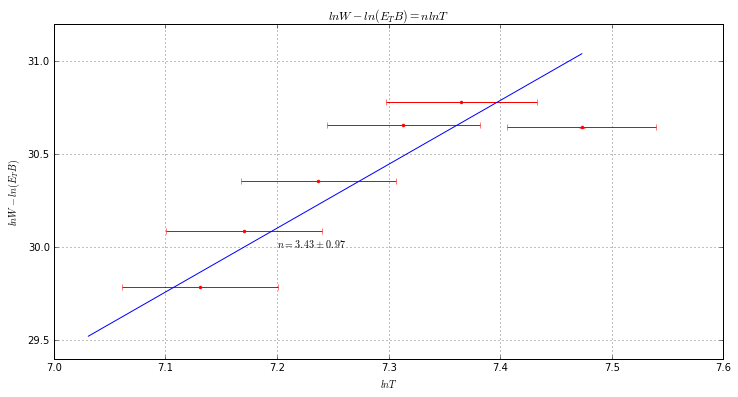

In [22]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot()

Werr = dataC['W, Вт']*np.sqrt((0.005/dataC['U, В'])**2 + (0.0005/dataC['I, А'])**2)
y = dataln['lnW-ln(EB)'].values 
yerr = 1/y * Werr
x = dataln['lnT'].values
Terr = np.sqrt([0.5**2 for i in range(len(x))])
xerr = 1/x * Terr

mydata = odr.RealData(x, y, sx=xerr, sy=yerr)
myodr = odr.ODR(mydata, linearStefanBolcman, beta0=[1.,2.])
myoutput = myodr.run()

x_new = np.linspace(x[0]-0.1, x[-1], 50)
y_new = linearStefanBolcman.fcn(myoutput.beta, x_new)

plt.xlabel("$lnT$")
plt.ylabel("$lnW - ln(E_{T}B)$")
plt.title("$lnW - ln(E_{T}B) = nlnT$")
plt.grid(True)


plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='k.',  color='r')
plt.plot(x_new, y_new, 'k',  color='b')
plt.text(7.2,30.0, r'$n = %.2f \pm %.2f$'%(round(myoutput.beta[0],2), round(myoutput.sd_beta[0],2)))
plt.show()

Найдём величину постоянной Стефана-Больцмана по формуле
$$\sigma = \frac{W}{\varepsilon_{T}ST^4}$$
при температуре больше 1700К

In [25]:
stefBolcHighTemp = pd.DataFrame()
stefBolcHighTemp['T, K'] = dataK['Tтерм(K)'][5:]
stefBolcHighTemp['sigma'] = pd.Series(dataC['W, Вт'][5:] / (E[5:]*0.36e-04*dataK['Tтерм(K)'][5:]**4))
stefBolcHighTemp['h'] = pd.Series((((2*(3.14159**5)*((1.38e-23)**4))/(15*((3e08)**2)*stefBolcHighTemp['sigma']))**(1.0/3)))
stefBolcHighTemp

,"T, K",sigma,h
5,1760,1.177638e-07,5.187795e-34


In [54]:
sigmaerr = stefBolcHighTemp['sigma'][5] * np.sqrt((Werr[5]/dataC['W, Вт'][5])**2 + ((dataK['Tтерм(K)'][5]**4)*4*(Terr[5]/dataK['Tтерм(K)'][5]))**2)
print "sigma= " + str(stefBolcHighTemp['sigma'][5])
print "h=" + str(np.average(stefBolcHighTemp['h'])) + " ± " + str(np.std(stefBolcHighTemp['h'])) + " Дж*с"

sigma= 1.17763751131e-07
h=5.18779520919e-34 ± 0.0 Дж*с


### Измерение "яркостной температуры" неоновой лампочки
Направить пирометр на неоновую лампочку. Измерить пирометром "яркостную температуру" неоновой лампы.

In [23]:
neon = pd.DataFrame()
# в градусах Цельсия
neon['Tярк'] = pd.Series([
        843,
        839,
        846,
        838
    ])
print np.average(neon['Tярк'])
print round(np.std(neon['Tярк']),1)

841.5
3.2


**Вывод(как можно объяснить, что на ощупь температура оказалась малой):**



### Вывод
Используя модели абсолютно чёрного тела (АЧТ) были произведены измерения температуры оптическим пирометром с исчезающей нитью и термопарой, исследовалось излучение накаленных тел с различной испускательной способностью (керамической трубки и двух металлических колец). На основе этого наблюдения был сделан вывод почему $T_{ярк}$ этих тел различны ($T_{ярк}$ зависит от материала, $T_{ярк}$ $ < $ $T_{терм}$ для не АЧТ). На полученных данных Таблицы 1 проверен закон Стефана-Больцмана (коэффициент при T n= , что соответствует зависимости $W = \varepsilon S \sigma T^4$). Определены постоянная Планка $h=$  и Стефана-Больцмана $\sigma=$ .